# Model and Hierarchy

In [3]:
import os
import sys

# Ensure project root is on sys.path so `surgical_phase_tool` is importable
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from surgical_phase_tool.config_loader import load_config
from surgical_phase_tool.models.resnet_multitask import PhaseToolNet

cfg = load_config()
model = PhaseToolNet(backbone_name=cfg['model']['backbone'], pretrained=False)
model

PhaseToolNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

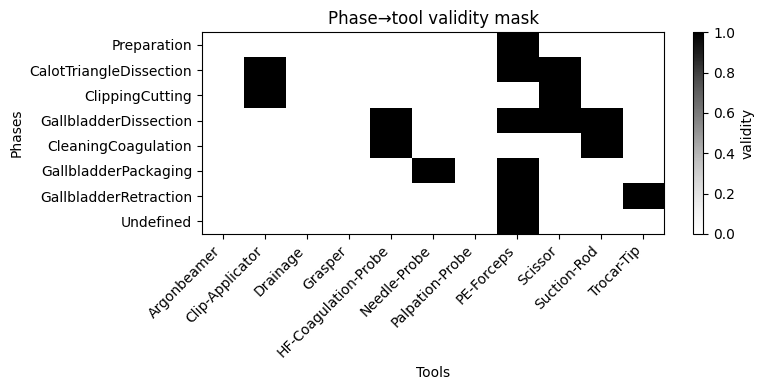

In [4]:
import matplotlib.pyplot as plt

from surgical_phase_tool.hierarchy.phase_tool_mask import build_phase_tool_mask
from surgical_phase_tool.dataset import PHASE_TO_ID, TOOL_COLUMNS

mask = build_phase_tool_mask().numpy()
phases = list(PHASE_TO_ID.keys())
tools = list(TOOL_COLUMNS)

plt.figure(figsize=(8, 4))
plt.imshow(mask, aspect='auto', cmap='Greys')
plt.yticks(range(len(phases)), phases)
plt.xticks(range(len(tools)), tools, rotation=45, ha='right')
plt.xlabel('Tools')
plt.ylabel('Phases')
plt.title('Phase→tool validity mask')
plt.colorbar(label='validity')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

allowed_table = pd.DataFrame(mask.astype(int), index=phases, columns=tools)
allowed_table

```python
# Hard masking (training)
phase_ids = phase_target.argmax(dim=-1)            # (B,)
sample_mask = mask[phase_ids]                     # (B, K)
large_neg = -1e4
masked_logits = tool_logits * sample_mask + large_neg * (1 - sample_mask)

# Soft masking (evaluation)
phase_probs = phase_logits.softmax(dim=-1)        # (B, P)
sample_mask = phase_probs @ mask                  # (B, K)
masked_logits = tool_logits * sample_mask + large_neg * (1 - sample_mask)
probs_with_hierarchy = masked_logits.sigmoid()
```